In [2]:
from datetime import datetime
import numpy as np             
import pandas as pd            
import matplotlib.pylab as plt 
%matplotlib inline             
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 6
import warnings
warnings.filterwarnings('ignore')

In [16]:
df=pd.read_excel('Plant Report 2019-21.xlsx')
df.head()

,Date,Total Yield [kWh]
0,2019-01-10,91.4
1,2019-01-11,173.2
2,2019-01-12,187.8
3,2019-01-13,242.4
4,2019-01-14,320.2


In [13]:
from scipy.interpolate import interp1d
import scipy.interpolate
df = df.interpolate()

In [15]:
df['Date'] = pd.to_datetime(df['Date'],infer_datetime_format=True)

In [17]:
df_index = df.set_index(['Date'])
df_index.head()

,Total Yield [kWh]
Date,
2019-01-10,91.4
2019-01-11,173.2
2019-01-12,187.8
2019-01-13,242.4
2019-01-14,320.2


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               889 non-null    datetime64[ns]
 1   Total Yield [kWh]  889 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 14.0 KB


In [19]:
df_index['Total Yield [kWh]'].isnull().sum()

0

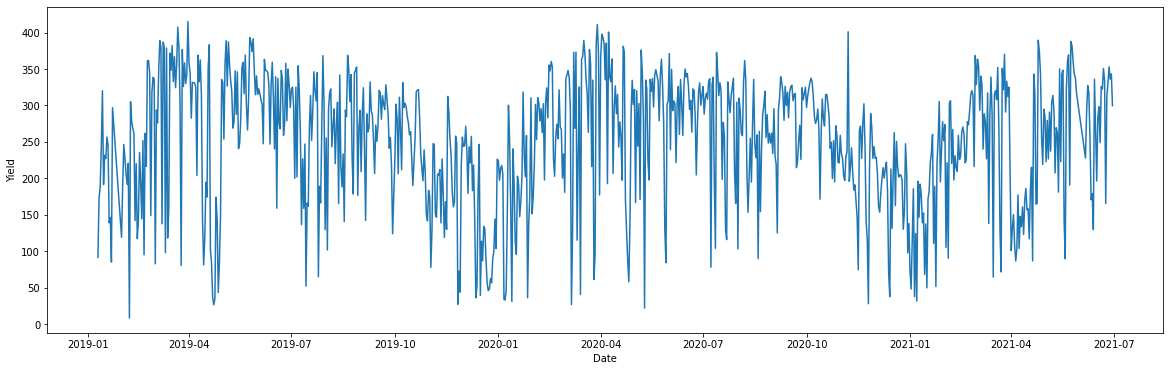

In [ ]:
plt.xlabel('Date')
plt.ylabel('Yield')
plt.plot(df_index)

In [ ]:
def test_stationarity(timeseries):
    
    #Moving Avg, SD
    movingAverage = timeseries.rolling(window=100).mean()
    movingSTD = timeseries.rolling(window=100).std()
    
    #Mean, SD constant?
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey–Fuller test:
    print('Results of Dickey Fuller Test:')

    dftest = adfuller(timeseries['Total Yield [kWh]'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

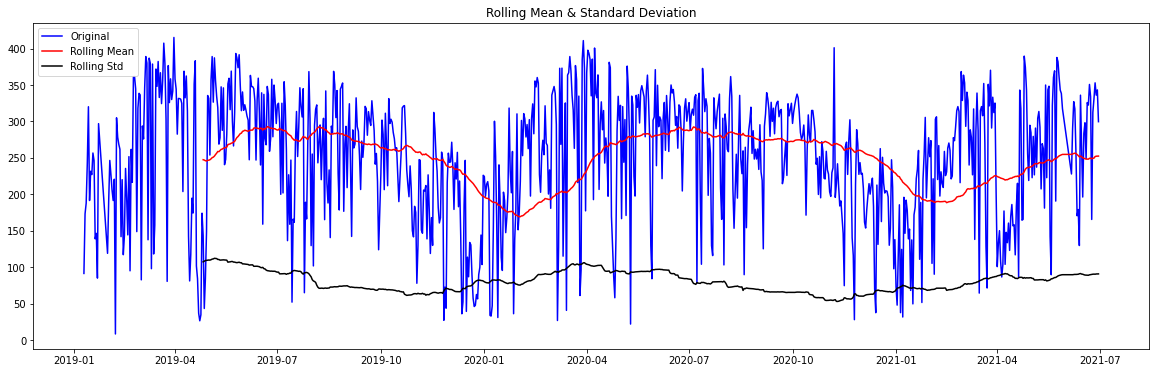

Results of Dickey Fuller Test:
Test Statistic                -6.046282e+00
p-value                        1.309523e-07
#Lags Used                     6.000000e+00
Number of Observations Used    8.820000e+02
Critical Value (1%)           -3.437786e+00
Critical Value (5%)           -2.864822e+00
Critical Value (10%)          -2.568518e+00
dtype: float64


In [ ]:
test_stationarity(df_index)

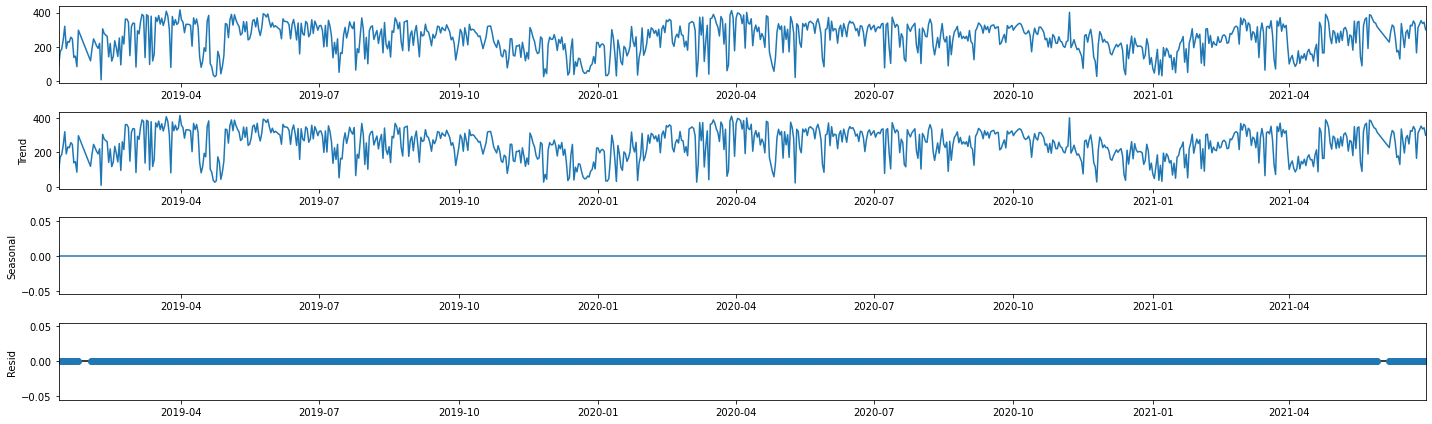

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_index,freq=1,model ='additive')
fig = decomposition.plot()

1. AR Model


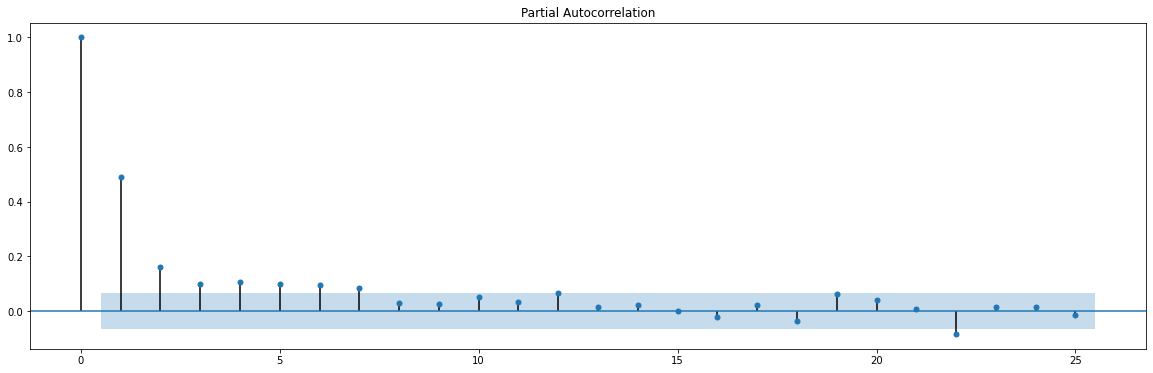

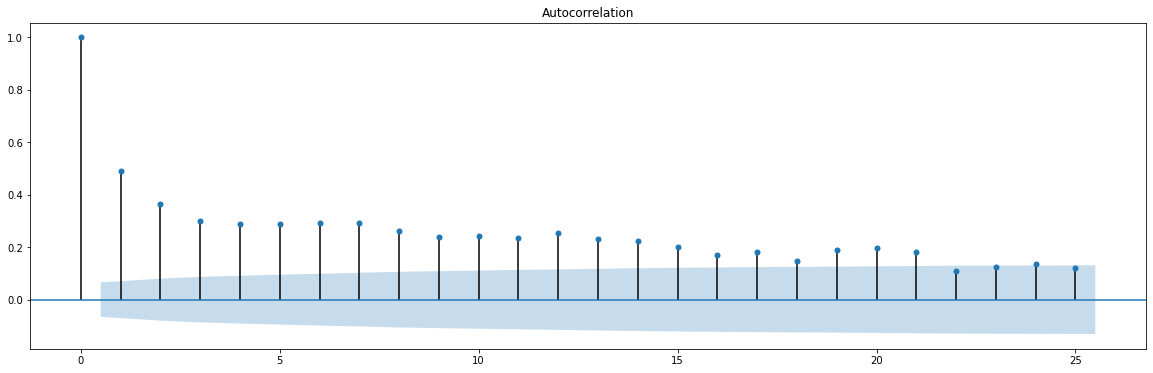

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
pacf = plot_pacf(df_index['Total Yield [kWh]'], lags =25)
acf = plot_acf(df_index['Total Yield [kWh]'], lags =25)

In [ ]:
# 1. Splitting into Trainning and Testing

X = df_index.values
train = X[:len(X)-7]
test = X[len(X)-7:]

In [ ]:
#!pip install statsmodels --upgrade

In [ ]:
import statsmodels
from statsmodels.tsa.ar_model import AutoReg

In [ ]:
# 2. Trainning the Model

model = AutoReg(train, lags=18).fit() # lags=18 determined by PACF

In [ ]:
print(model.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  882
Model:                    AutoReg(18)   Log Likelihood               -4939.614
Method:               Conditional MLE   S.D. of innovations             73.568
Date:                Fri, 30 Jul 2021   AIC                              8.643
Time:                        07:10:53   BIC                              8.753
Sample:                            18   HQIC                             8.685
                                  882                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.7809     12.395      4.178      0.000      27.487      76.074
y.L1           0.3536      0.034     10.400      0.000       0.287       0.420
y.L2           0.0778      0.036      2.158      0.0

[296.18779377 277.02113208 277.02238716 278.92016674 277.96163288
 284.64362131 278.54510748]


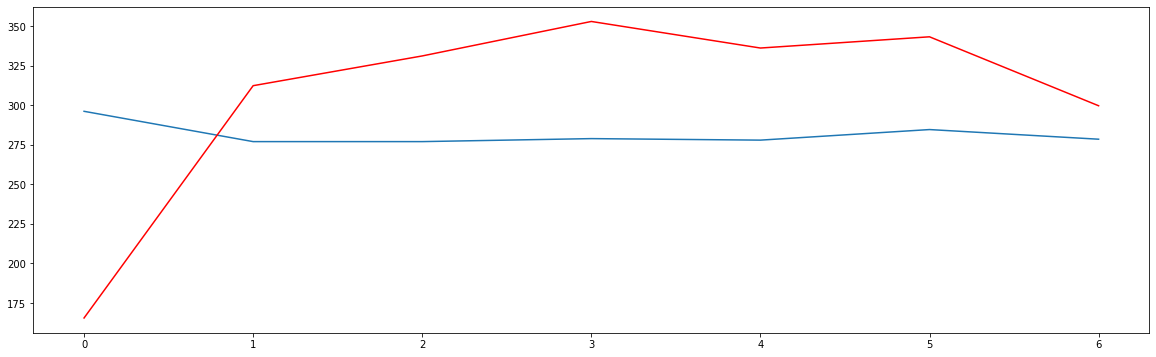

In [ ]:
# 3. Predicting

pred = model.predict(start = len(train),end = len(X)-1, dynamic = False)

from matplotlib import pyplot
pyplot.plot(pred)
pyplot.plot(test, color = 'red')
print(pred)


In [ ]:
# 4. Calculating the Error

from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(test,pred))
rmse

69.72712049888564

2. MA Model

In [ ]:
df_ma = df_index.copy()

In [ ]:
df_ma_w12 = df_ma.rolling(window = 12).mean()
df_ma_w12['SMA_12']=df_ma_w12['Total Yield [kWh]']

In [ ]:
df_ma_w12['SMA_12'].isnull().sum()

11

In [ ]:
df_ma_w12_removednull = df_ma_w12['SMA_12'].dropna()

df_ma_w12_removednull.isnull().sum()

0

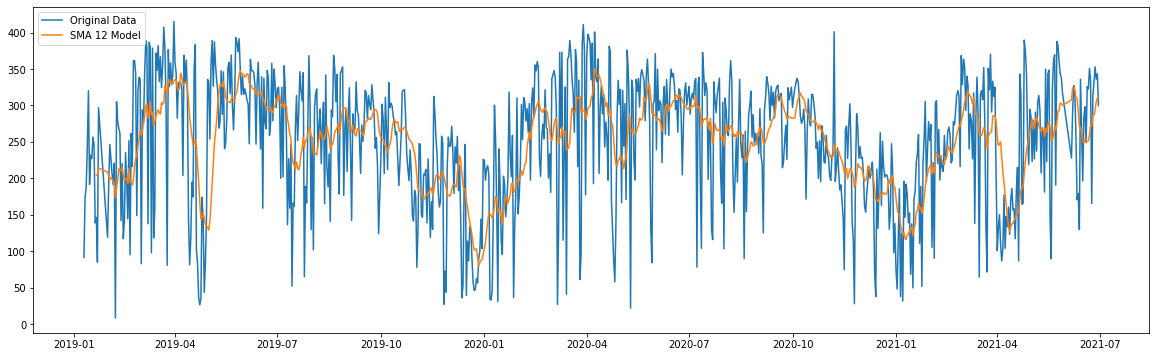

In [ ]:
plt.plot(df_ma['Total Yield [kWh]'], label = 'Original Data')
plt.plot(df_ma_w12_removednull, label = "SMA 12 Model")
plt.legend()
plt.show()

In [ ]:
# Calculating the Error

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true-y_pred)/y_true)) *100

mape(df_ma['Total Yield [kWh]'], df_ma_w12_removednull)

41.18624293666036

3. ARIMA Model


In [ ]:
#!pip install pmdarima
import pmdarima
from pmdarima import auto_arima
stepwise_fit = auto_arima(df_index['Total Yield [kWh]'], trace=True,suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10490.449, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10246.147, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10322.789, Time=0.43 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12446.750, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10224.533, Time=0.11 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10217.843, Time=0.16 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=10210.052, Time=0.29 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=10203.177, Time=0.33 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=10204.331, Time=0.56 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=10211.383, Time=0.44 sec
 ARIMA(5,0,0)(0,0,0)[0]             : AIC=inf, Time=0.25 sec

Best model:  ARIMA(5,0,0)(0,0,0)[0] intercept
Total fit time: 4.351 seconds


We can see the best ARIMA model seems to be of the order (5,0,0) with the minimum AIC score=10203.177

In [ ]:
# 1. Splitting into Test and Train

trainA=df_index.iloc[:-30]
testA=df.iloc[-30:]
print(trainA.shape,testA.shape)

(859, 1) (30, 2)


In [ ]:
# 2. Fitting ARIMA

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(trainA['Total Yield [kWh]'],order=(5,0,0))
model=model.fit()
print(model.summary())

                              ARMA Model Results                              
Dep. Variable:      Total Yield [kWh]   No. Observations:                  859
Model:                     ARMA(5, 0)   Log Likelihood               -4927.697
Method:                       css-mle   S.D. of innovations             74.990
Date:                Fri, 30 Jul 2021   AIC                           9869.394
Time:                        07:11:21   BIC                           9902.685
Sample:                             0   HQIC                          9882.140
                                                                              
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     248.6032      8.206     30.297      0.000     232.520     264.686
ar.L1.Total Yield [kWh]     0.3729      0.034     10.953      0.000       0.306       0.440


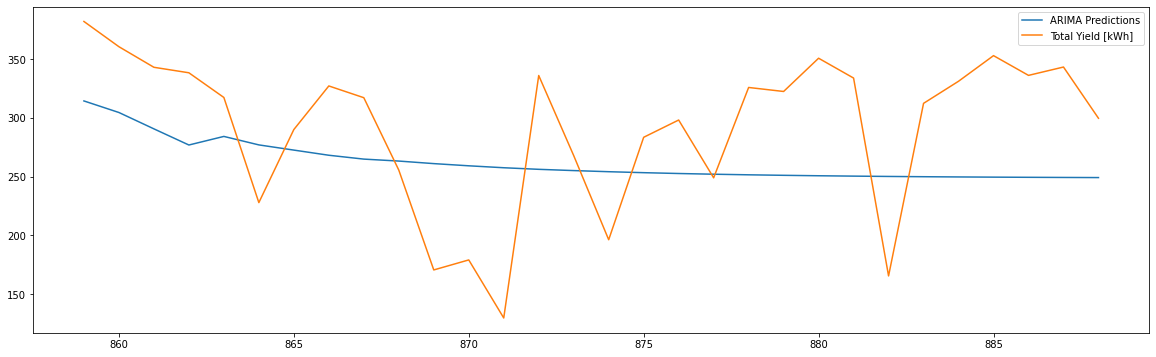

In [ ]:
# 3. Making Predictions

start=len(trainA)
end=len(trainA)+len(testA)-1
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
pred.plot(legend=True)
testA['Total Yield [kWh]'].plot(legend=True)

In [ ]:
# 4. Calculating Error

from sklearn.metrics import mean_squared_error
from math import sqrt
testA['Total Yield [kWh]'].mean()
rmse=sqrt(mean_squared_error(pred,testA['Total Yield [kWh]']))
print(rmse)


69.06052293968754


4. SARIMA Model

In [ ]:
# 1. Defining the model

import itertools
import statsmodels.api as sm

p = range(0, 3)
d = range(1,2)
q = range(0, 4)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

for param in pdq:
    for param_seasonal in seasonal_pdq:

            mod = sm.tsa.statespace.SARIMAX(df['Total Yield [kWh]'],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 1, 1) x (0, 1, 1, 12)
SARIMAX: (0, 1, 1) x (0, 1, 2, 12)
SARIMAX: (0, 1, 2) x (0, 1, 3, 12)
SARIMAX: (0, 1, 2) x (1, 1, 0, 12)
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:10910.781007277514
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:10235.846984279291
ARIMA(0, 1, 0)x(0, 1, 2, 12)12 - AIC:10090.61351545857
ARIMA(0, 1, 0)x(0, 1, 3, 12)12 - AIC:9951.536885988324
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:10527.456328298758
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:10236.94175772777
ARIMA(0, 1, 0)x(1, 1, 2, 12)12 - AIC:10090.412896613827
ARIMA(0, 1, 0)x(1, 1, 3, 12)12 - AIC:9940.238637730505
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:10286.150472522788
ARIMA(0, 1, 0)x(2, 1, 1, 12)12 - AIC:10103.986880555141
ARIMA(0, 1, 0)x(2, 1, 2, 12)12 - AIC:10092.299315761156
ARIMA(0, 1, 0)x(2, 1, 3, 12)12 - AIC:9927.55710541304
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:10632.842458615733
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:9957.168373673076
ARIMA(0, 1, 1)x(0, 1, 2, 1

In [ ]:
# 2. Finding the p,d,q values

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                  Total Yield [kWh]   No. Observations:                  889
Model:             SARIMAX(2, 1, 3)x(2, 1, 3, 12)   Log Likelihood               -4814.808
Date:                            Fri, 30 Jul 2021   AIC                           9651.617
Time:                                    10:44:08   BIC                           9703.632
Sample:                                         0   HQIC                          9671.557
                                            - 889                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1436      0.012     95.562      0.000       1.120       1.167
ar.L2         -0.9867      0.012   

In [ ]:
# 3. Fitting the model

from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(df_index['Total Yield [kWh]'], order=(2, 1, 3), seasonal_order = (2, 1, 3, 12), trend='ct')
model_fit = model.fit(disp= True)

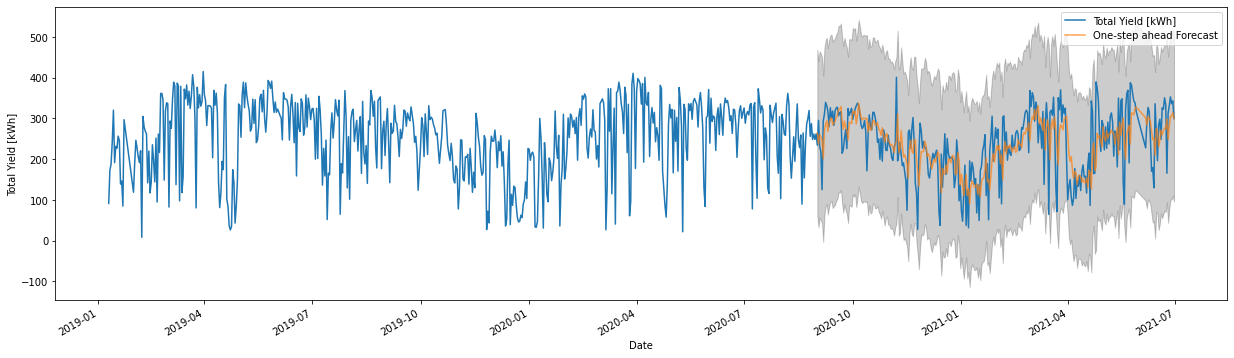

In [ ]:
# 4. Predicting Values
 
pred = model_fit.get_prediction(start=pd.to_datetime('2020-09-01'), dynamic=False)
pred_ci = pred.conf_int()
 
ax = df_index.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(21, 6))
 
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
 
ax.set_xlabel('Date')
ax.set_ylabel('Total Yield [kWh]')
plt.legend()
 
plt.show()

In [ ]:
df_index['Total Yield [kWh]'].isnull().sum()

0

In [ ]:
y_forecasted = pred.predicted_mean
y_truth = df_index['2020-09-01':]

mse = ((y_forecasted - y_truth) ** 2).mean()
mse

2020-09-01 00:00:00   NaN
2020-09-02 00:00:00   NaN
2020-09-03 00:00:00   NaN
2020-09-04 00:00:00   NaN
2020-09-05 00:00:00   NaN
                       ..
2021-06-27 00:00:00   NaN
2021-06-28 00:00:00   NaN
2021-06-29 00:00:00   NaN
2021-06-30 00:00:00   NaN
Total Yield [kWh]     NaN
Length: 297, dtype: float64

In [ ]:
y_truth.isnull().sum()

Total Yield [kWh]    0
dtype: int64

In [ ]:
y_truth


,Total Yield [kWh]
Date,
2020-09-01,234.2
2020-09-02,295.5
2020-09-03,230.7
2020-09-04,219.0
2020-09-05,125.2
...,...
2021-06-26,331.2
2021-06-27,353.0
2021-06-28,336.2


In [ ]:
y_forecasted

Date
2020-09-01    264.560255
2020-09-02    237.048831
2020-09-03    260.793707
2020-09-04    254.217566
2020-09-05    246.756797
                 ...    
2021-06-26    280.444681
2021-06-27    305.120452
2021-06-28    305.360815
2021-06-29    314.351757
2021-06-30    300.237105
Name: predicted_mean, Length: 296, dtype: float64

In [ ]:
'''df_csv
save in csv form'''

In [ ]:
import pickle

In [ ]:
pickle.dump(model, open('model_save', 'wb'))

In [ ]:
pip freeze> requirements.txt